Make spatial plots of predicted melt data
===

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid, cm
import numpy as np
import math

import pandas as pd
from model import Model
from plotUtils import PlotUtils
# import numpy as np
# from scipy import stats
# import os
# import seaborn as sns
# import matplotlib.ticker as ticker
# from matplotlib.lines import Line2D
# from matplotlib.text import Text

# from GCNet import GCNet

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

import matplotlib.colors as colors

Spatial bounds
---

In [2]:
minLon = -70 + 360
maxLon = -15 + 360
minLat = 58
maxLat = 86.5

midLat = (minLat + maxLat) / 2
midLon = (minLon  +maxLon) / 2

print "Latitudes", minLat,minLat,maxLat
print "Longitudes", minLon,midLon,maxLon

Latitudes 58 58 86.5
Longitudes 290 317 345


Function: Load data
---

In [11]:
def loadData( model, branch, ens, mon, suff, predVar = "tas" ):
    if branch == "historical":
        yr1 = "1996"
        yr2 = "2005"

    if branch in ( "rcp85", "1pt5degC"):
        yr1 = "2071"
        yr2 = "2080"

    try:
        mms = "%02d" % mon
    except:
        mms = mon

    if model == "cesmlw":
        enss = "ens"
    else:
        try:
            enss = "%03d" % ens
        except:
            enss = ens

    yrs = yr1+"-"+yr2
    
    modelDataDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_%s" % model
    readVar = "melt"
    if "cesm" in model:
        if suff is None:
            modelDataFN = "wrf_%s_%s_%s_beta_%s_%s.nc" % ( model, enss, predVar, yrs, mms )
        else:
            modelDataFN = "wrf_%s_%s_%s_beta_%s_%s_adj.nc" % ( model, enss, predVar, yrs, mms )
    else:
        modelDataFN = "wrf_%s_%s_beta_%s_%s.nc" % ( model, predVar, yrs, mms )
    
    if model == "melt":
        modelDataDir = "/Users/dbr/Documents/gismelt/mote_sfc_melt"
        modelDataFN = "Mote_%s_%s.nc" % ( yrs, mms )
        readVar = "greenland_surface_melt"
    
    print modelDataFN
    D = Model(None, modelDataDir+"/"+modelDataFN)
    X = np.array( D.loadData( readVar ) )
    
    if model == "melt":
        Xf = X.astype(float)
        id = ( X < 0 )
#         Xf[id] = np.nan
        Xf[id] = 0
        X = Xf

    return X, yrs, mms

Function: Create title
---

In [39]:
def createTitle( model, branch, ens, mms ):
    months = dict( [ \
                      ( 'JJA', "JJA" ), \
                      ( '06', "Jun" ), \
                      ( '07', "Jul" ), \
                      ( '08', "Aug" ), \
                   ] )
    
    branches = dict( [ \
                      ( 'historical', "Hist" ), \
                      ( 'rcp85', "RCP8.5" ), \
                      ( '1pt5degC', "1.5 $^\circ$C" ), \
                   ] )
    if model == "cesmlw":
        enss = None
    else:
        try:
            enss = "%02d" % ens
        except:
            if model == "cesmle":
                enss = "Ens Avg"
            else:
                enss = ens
            
    if model == "melt":
        modelStr = "Obs"
    else:
        modelStr = model.upper()
        
    try:
        monStr = months[mms]
    except:
        monStr = mms
        
    if model in ("melt", "erai"):
        branchStr = ''
    else:
        try:
            branchStr = branches[branch]
        except:
            branchStr = branch
    
    if enss is None:
        titleStr = modelStr+" "+branchStr
    else:
        if model == "cesmle":
            titleStr = modelStr+"\n"+branchStr+" "+enss
        else:
            titleStr = modelStr+" "+branchStr+" "+enss
    
    return titleStr

Function: create colorbar
---

In [192]:
def createColorBar( cs, cbtitle, axes, loc = 'bottom', format = None, fontSize = 18, cbdy = 0.04 ):
    cbshrink = 0.8
    xShrink = (1-cbshrink)/2
    
    axesL = axes.ravel().tolist()
        
    if format is None:
        cbar = fig.colorbar(cs, location=loc,  ax=axesL, \
                            shrink = cbshrink);
    else:
        cbar = fig.colorbar(cs, location=loc,  ax=axesL, \
                            shrink = cbshrink, format=format);
    
    cbar.ax.set_xlabel(cbtitle, fontsize=fontSize)
    pos1 = cbar.ax.get_position()
    xLeft = pos1.x0*(1+xShrink)
    pos2 = [xLeft, pos1.y0+cbdy, pos1.x1*cbshrink, pos1.y1+cbdy]
    cbar.ax.set_position( pos2 )
    
    imaxes = plt.gca()
    plt.sca(cbar.ax)
    plt.xticks(fontsize=fontSize)
    plt.sca(imaxes)

Function: "Normalize" function to center a colorbar on a specific value
---

In [6]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

Global data
---

In [7]:
gFile = "wrf_geog.nc"
G = Model( None, gFile )
lat = np.array( G.loadData( "lat" ) )
nLat = len(lat)
lon = np.array( G.loadData( "lon" ) )
nLon = len(lon)

doCN = 0  # add single contour?
cnSuff = "_cn"

# mon = 6
# mon = 7
# mon = 8
mon = "JJA"

# ens = "ens"
ens = 1

Setup plotting
---

In [66]:
plotStr = "iuggmelt"
# plotOptions = { "saveFigure": False }
plotOptions = { "saveFigure": True }

P = PlotUtils( plotOptions )

Load Mote ice sheet mask
---

In [9]:
fn = "icesheet_mask.nc"
ncfn = Dataset(fn, "r")
icemask2d = np.array( ncfn.variables[ "icemask" ] )

Load data
---

In [49]:
models = ["melt", "erai"]
for e in range(1,23):
    models.append( "cesmle" )
models.append( "cesmlw" )
print models
print ""

branches = ( "historical", "historical", "historical", "rcp85",  "1pt5degC" )
branches = ["historical", "historical"]
for e in range(1,12):
    branches.append( "historical" )
for e in range(1,12):
    branches.append( "rcp85" )
branches.append( "1pt5degC" )
print branches
print ""

ensList = range(1,11)
ensList.append("ens")
print ensList
print ""

ensIndex = [None, None]
for e in ensList:
    ensIndex.append( e )
for e in ensList:
    ensIndex.append( e )
ensIndex.append( None )
print ensIndex

['melt', 'erai', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmle', 'cesmlw']

['historical', 'historical', 'historical', 'historical', 'historical', 'historical', 'historical', 'historical', 'historical', 'historical', 'historical', 'historical', 'historical', 'rcp85', 'rcp85', 'rcp85', 'rcp85', 'rcp85', 'rcp85', 'rcp85', 'rcp85', 'rcp85', 'rcp85', 'rcp85', '1pt5degC']

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'ens']

[None, None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'ens', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'ens', None]


In [27]:
predVar = "tas"
# predVar = "tasmax"
index = 0
for model, branch, ens in zip( models, branches, ensIndex ):
    M, yrs, mms = loadData( model, branch, ens, mon, "adj", predVar )

    nRec, nLat, nLon = M.shape
    if model == "melt":   # Mote obs data
        icemask3d = np.repeat( icemask2d[None,:,:],nRec,axis=0)
        noice = (icemask3d < 1)
        M[noice] = np.nan
    if index == 0:
        melt = np.empty( [len(models)+20, nRec, nLat, nLon] )
        meltSum = np.empty( [len(models)+20, nLat, nLon] )

    melt[index,:,:,:] = M
    meltSum[index,:,:] = np.sum( M, axis = 0 )

    index += 1

# issues with "_FillValue" mean there are some VERY large negative values in meltSum,
# so let's change those to nan.
nodata = (meltSum < 0)
meltSum[nodata] = np.nan

# calculate melt fraction
meltFrac = meltSum / nRec * 100.

# ...and how many models were there?
nModels = meltSum.shape[0]

Mote_1996-2005_JJA.nc
wrf_erai_tas_beta_1996-2005_JJA.nc
wrf_cesmle_001_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_002_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_003_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_004_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_005_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_006_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_007_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_008_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_009_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_010_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_ens_tas_beta_1996-2005_JJA_adj.nc
wrf_cesmle_001_tas_beta_2071-2080_JJA_adj.nc
wrf_cesmle_002_tas_beta_2071-2080_JJA_adj.nc
wrf_cesmle_003_tas_beta_2071-2080_JJA_adj.nc
wrf_cesmle_004_tas_beta_2071-2080_JJA_adj.nc
wrf_cesmle_005_tas_beta_2071-2080_JJA_adj.nc
wrf_cesmle_006_tas_beta_2071-2080_JJA_adj.nc
wrf_cesmle_007_tas_beta_2071-2080_JJA_adj.nc
wrf_cesmle_008_tas_beta_2071-2080_JJA_adj.nc
wrf_cesmle_009_tas_beta_2071-2080_JJA_adj.nc
wrf_cesmle_010_tas_beta_2071-2080_JJA_adj.n

/Library/Python/2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in less


Plot melt sum, i.e., how many days did melt occur
---

Saving figure to wrf_iuggmelt_tas_meltSum.eps


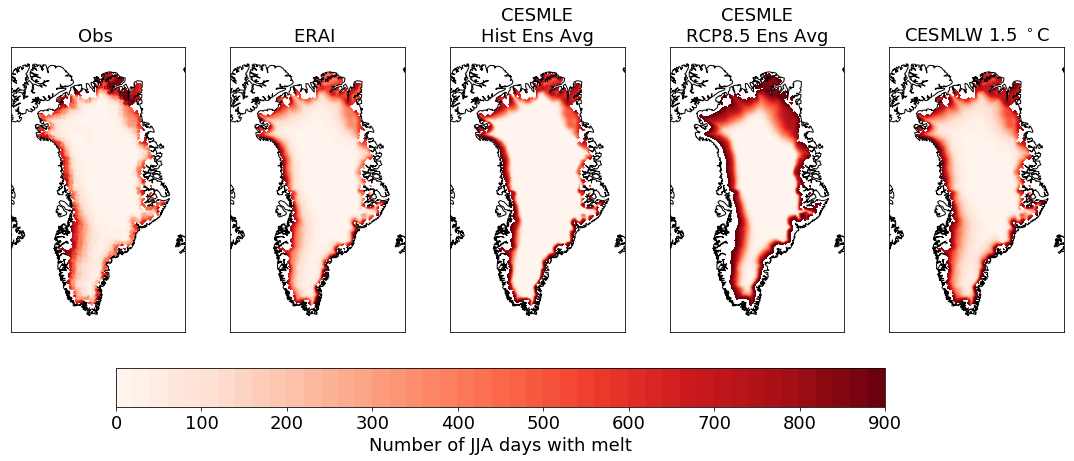

In [67]:
mdlIndex = (0, 1, 12, 23, 24)
nPlots = len( mdlIndex )
fig, axes = plt.subplots(nrows=1, ncols=nPlots, figsize=(3*nPlots,2*nPlots))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.arange( 0, nRec, 20 )
for index in range( nPlots ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltSum[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("Reds") )
    axesF[index].set_title( createTitle( models[mdlIndex[index]], \
                                         branches[mdlIndex[index]], \
                                         ensIndex[mdlIndex[index]], \
                                         mms ),  fontsize=18);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Number of '+mms+' days with melt', axes )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum" )

Plot melt fraction, i.e., what fraction of period did melt occur
---

Saving figure to wrf_iuggmelt_tas_meltFrac.eps


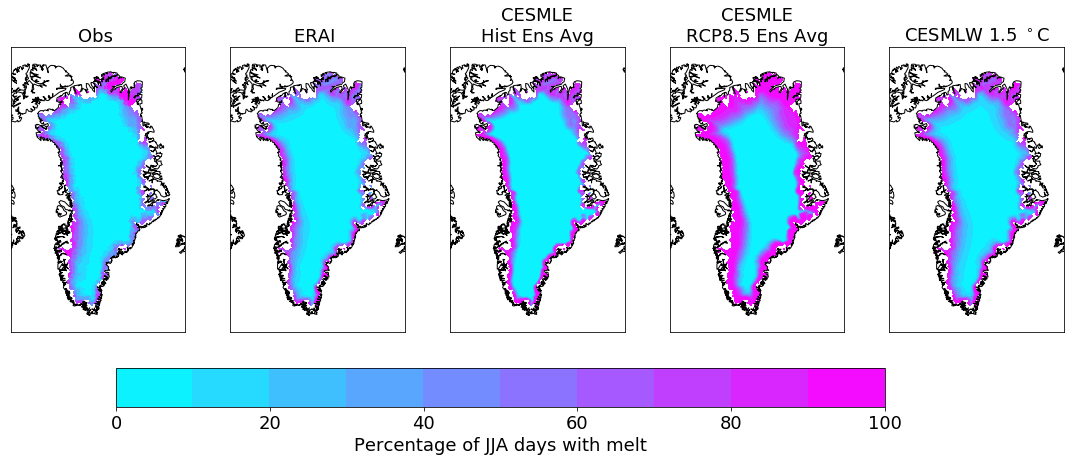

In [68]:
mdlIndex = (0, 1, 12, 23, 24)
nPlots = len( mdlIndex )
fig, axes = plt.subplots(nrows=1, ncols=nPlots, figsize=(3*nPlots,2*nPlots))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.linspace( 0., 100., 11 )
for index in range( nPlots ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltFrac[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("cool") )
    axesF[index].set_title( createTitle( models[mdlIndex[index]], \
                                         branches[mdlIndex[index]], \
                                         ensIndex[mdlIndex[index]], \
                                         mms ),  fontsize=18);

plt.tight_layout( w_pad=4, h_pad=0.01 )    

createColorBar( cs, 'Percentage of '+mms+' days with melt', axes )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac" )

Plot melt sum: historical ensemble members
---

Saving figure to wrf_iuggmelt_tas_meltSum_ensmbrs_hist.eps


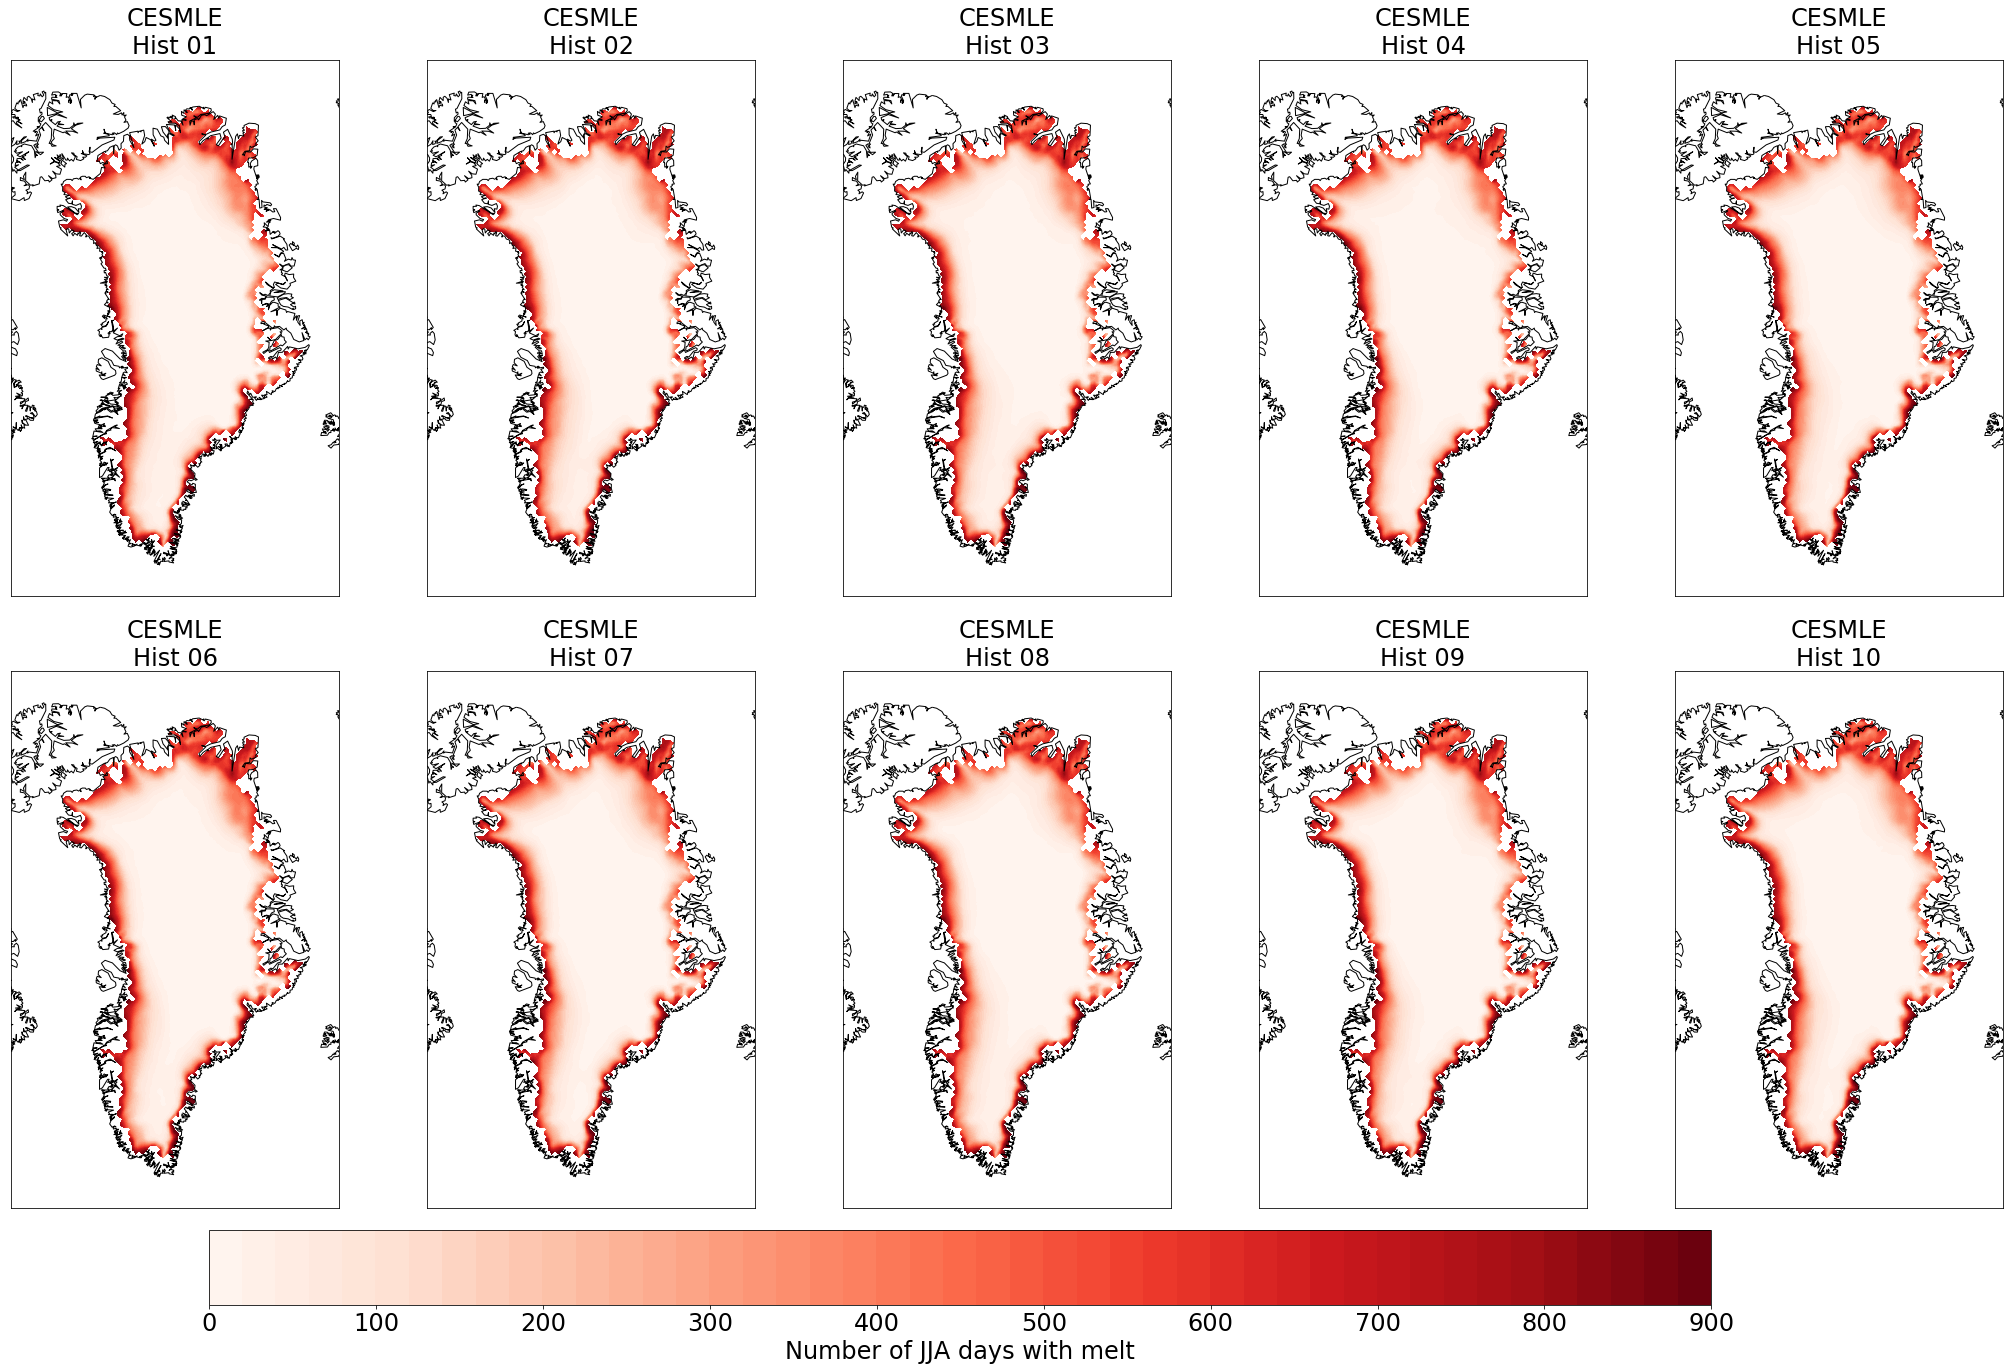

In [74]:
mdlIndex = []
for e in ensList[:-1]:
    mdlIndex.append( e+1 )
nPlots = len( mdlIndex )
fig, axes = plt.subplots(nrows=2, ncols=nPlots/2, figsize=(3*nPlots,2.5*nPlots))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.arange( 0, nRec, 20 )
for index in range( nPlots ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltSum[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("Reds") )
    axesF[index].set_title( createTitle( models[mdlIndex[index]], \
                                         branches[mdlIndex[index]], \
                                         ensIndex[mdlIndex[index]], \
                                         mms ),  fontsize=24);

plt.tight_layout( pad=8, h_pad=20 )    

createColorBar( cs, 'Number of '+mms+' days with melt', axes, fontSize=24 )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_ensmbrs_hist" )

Plot melt sum: rcp8.5 ensemble members
---

Saving figure to wrf_iuggmelt_tas_meltSum_ensmbrs_rcp85.eps


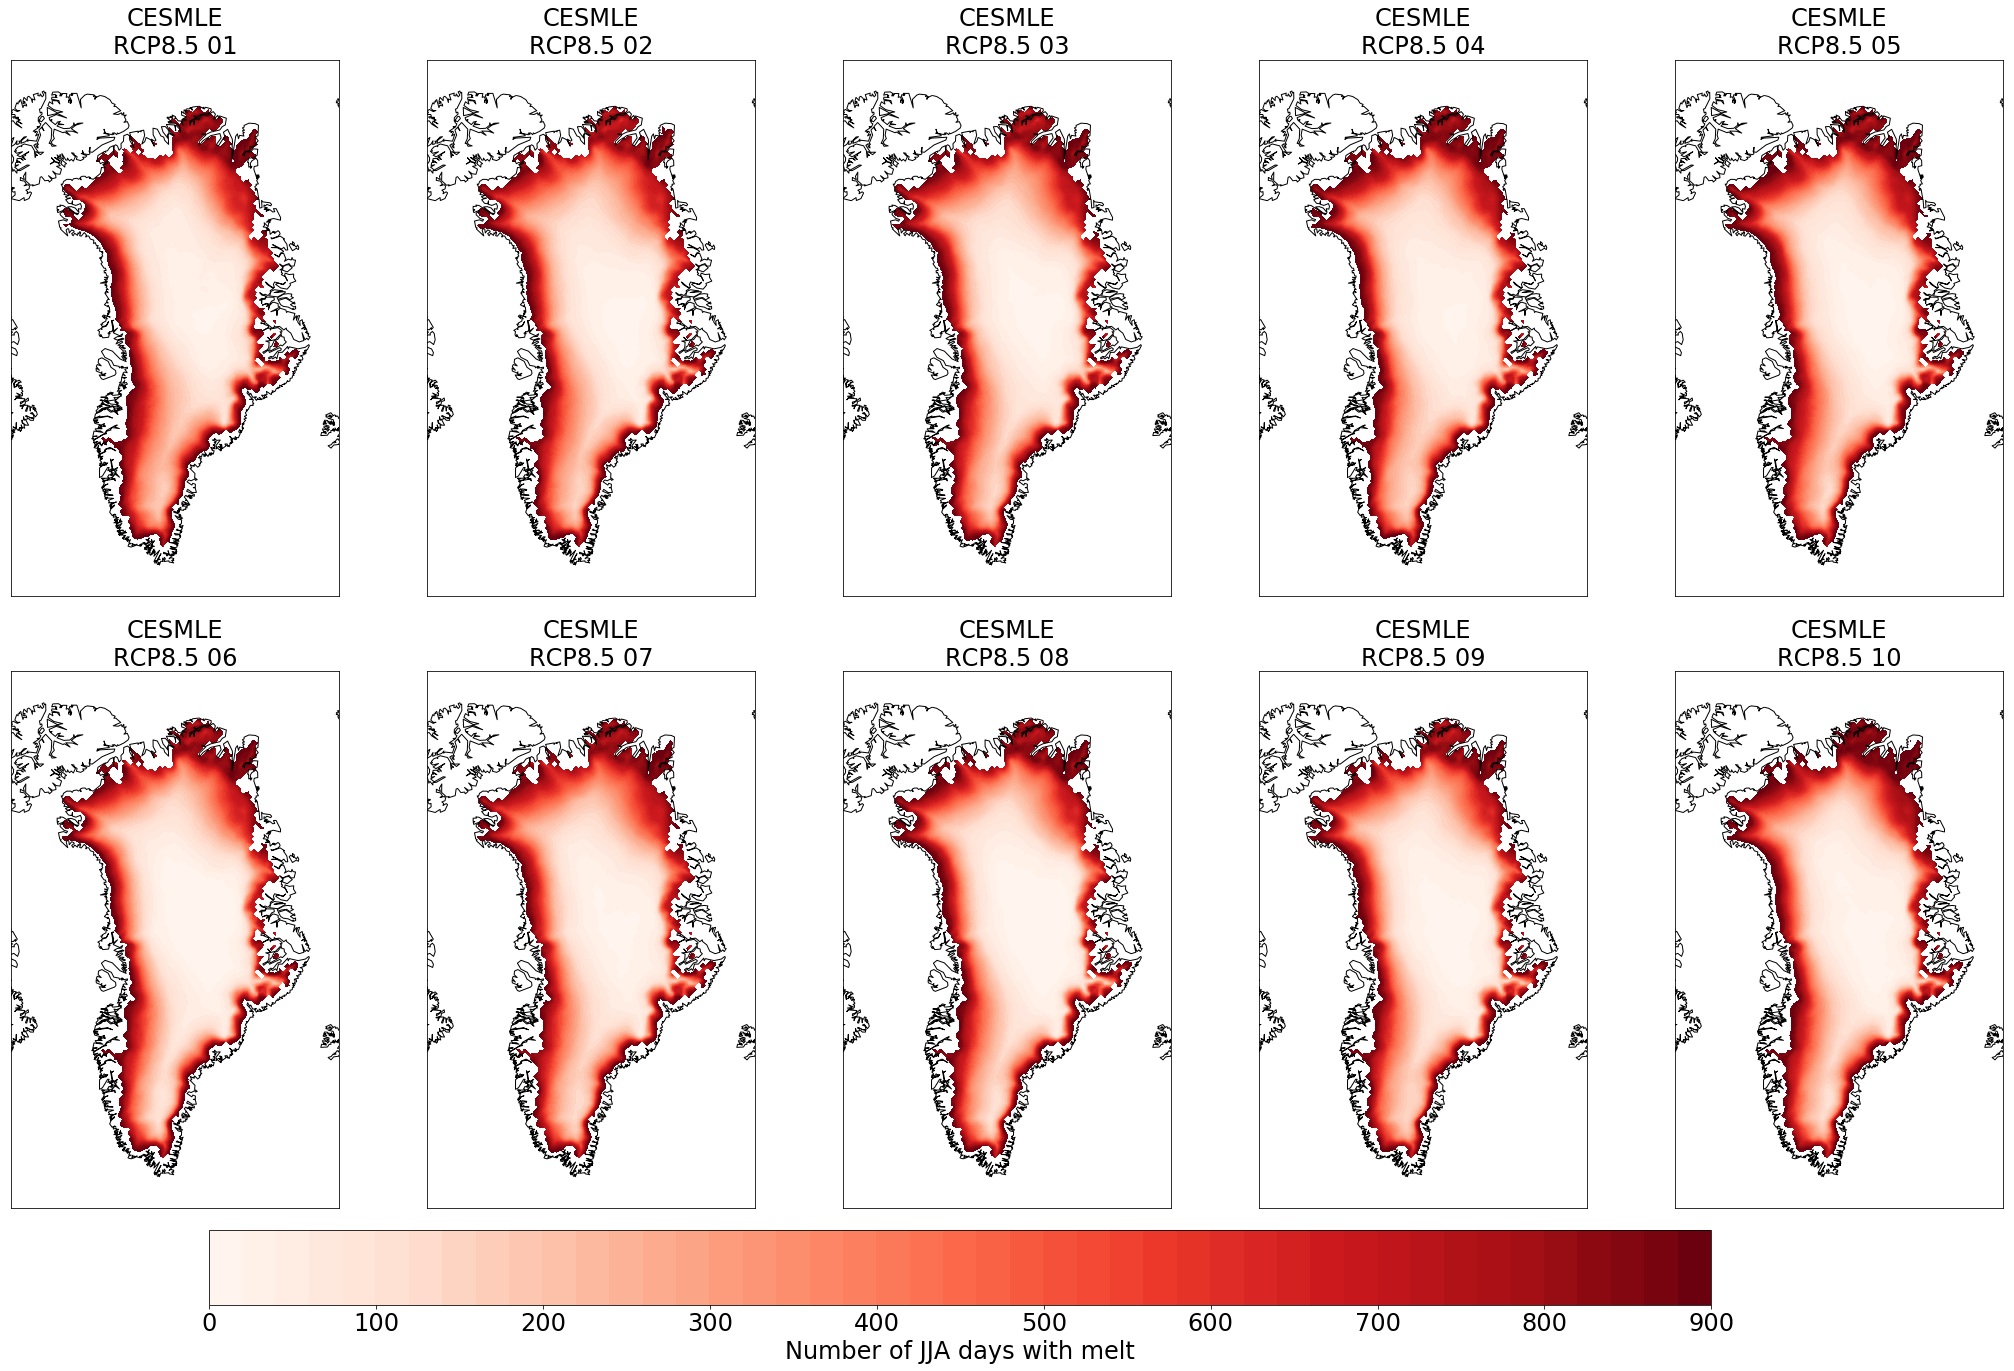

In [75]:
mdlIndex = []
for e in ensList[:-1]:
    mdlIndex.append( e+1+11 )
nPlots = len( mdlIndex )
fig, axes = plt.subplots(nrows=2, ncols=nPlots/2, figsize=(3*nPlots,2.5*nPlots))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.arange( 0, nRec, 20 )
for index in range( nPlots ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltSum[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("Reds") )
    axesF[index].set_title( createTitle( models[mdlIndex[index]], \
                                         branches[mdlIndex[index]], \
                                         ensIndex[mdlIndex[index]], \
                                         mms ),  fontsize=24);

plt.tight_layout( pad=8, h_pad=20 )    

createColorBar( cs, 'Number of '+mms+' days with melt', axes, fontSize=24 )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_ensmbrs_rcp85" )

Plot melt frac: historical ensemble members
---

Saving figure to wrf_iuggmelt_tas_meltFrac_ensmbrs_hist.eps


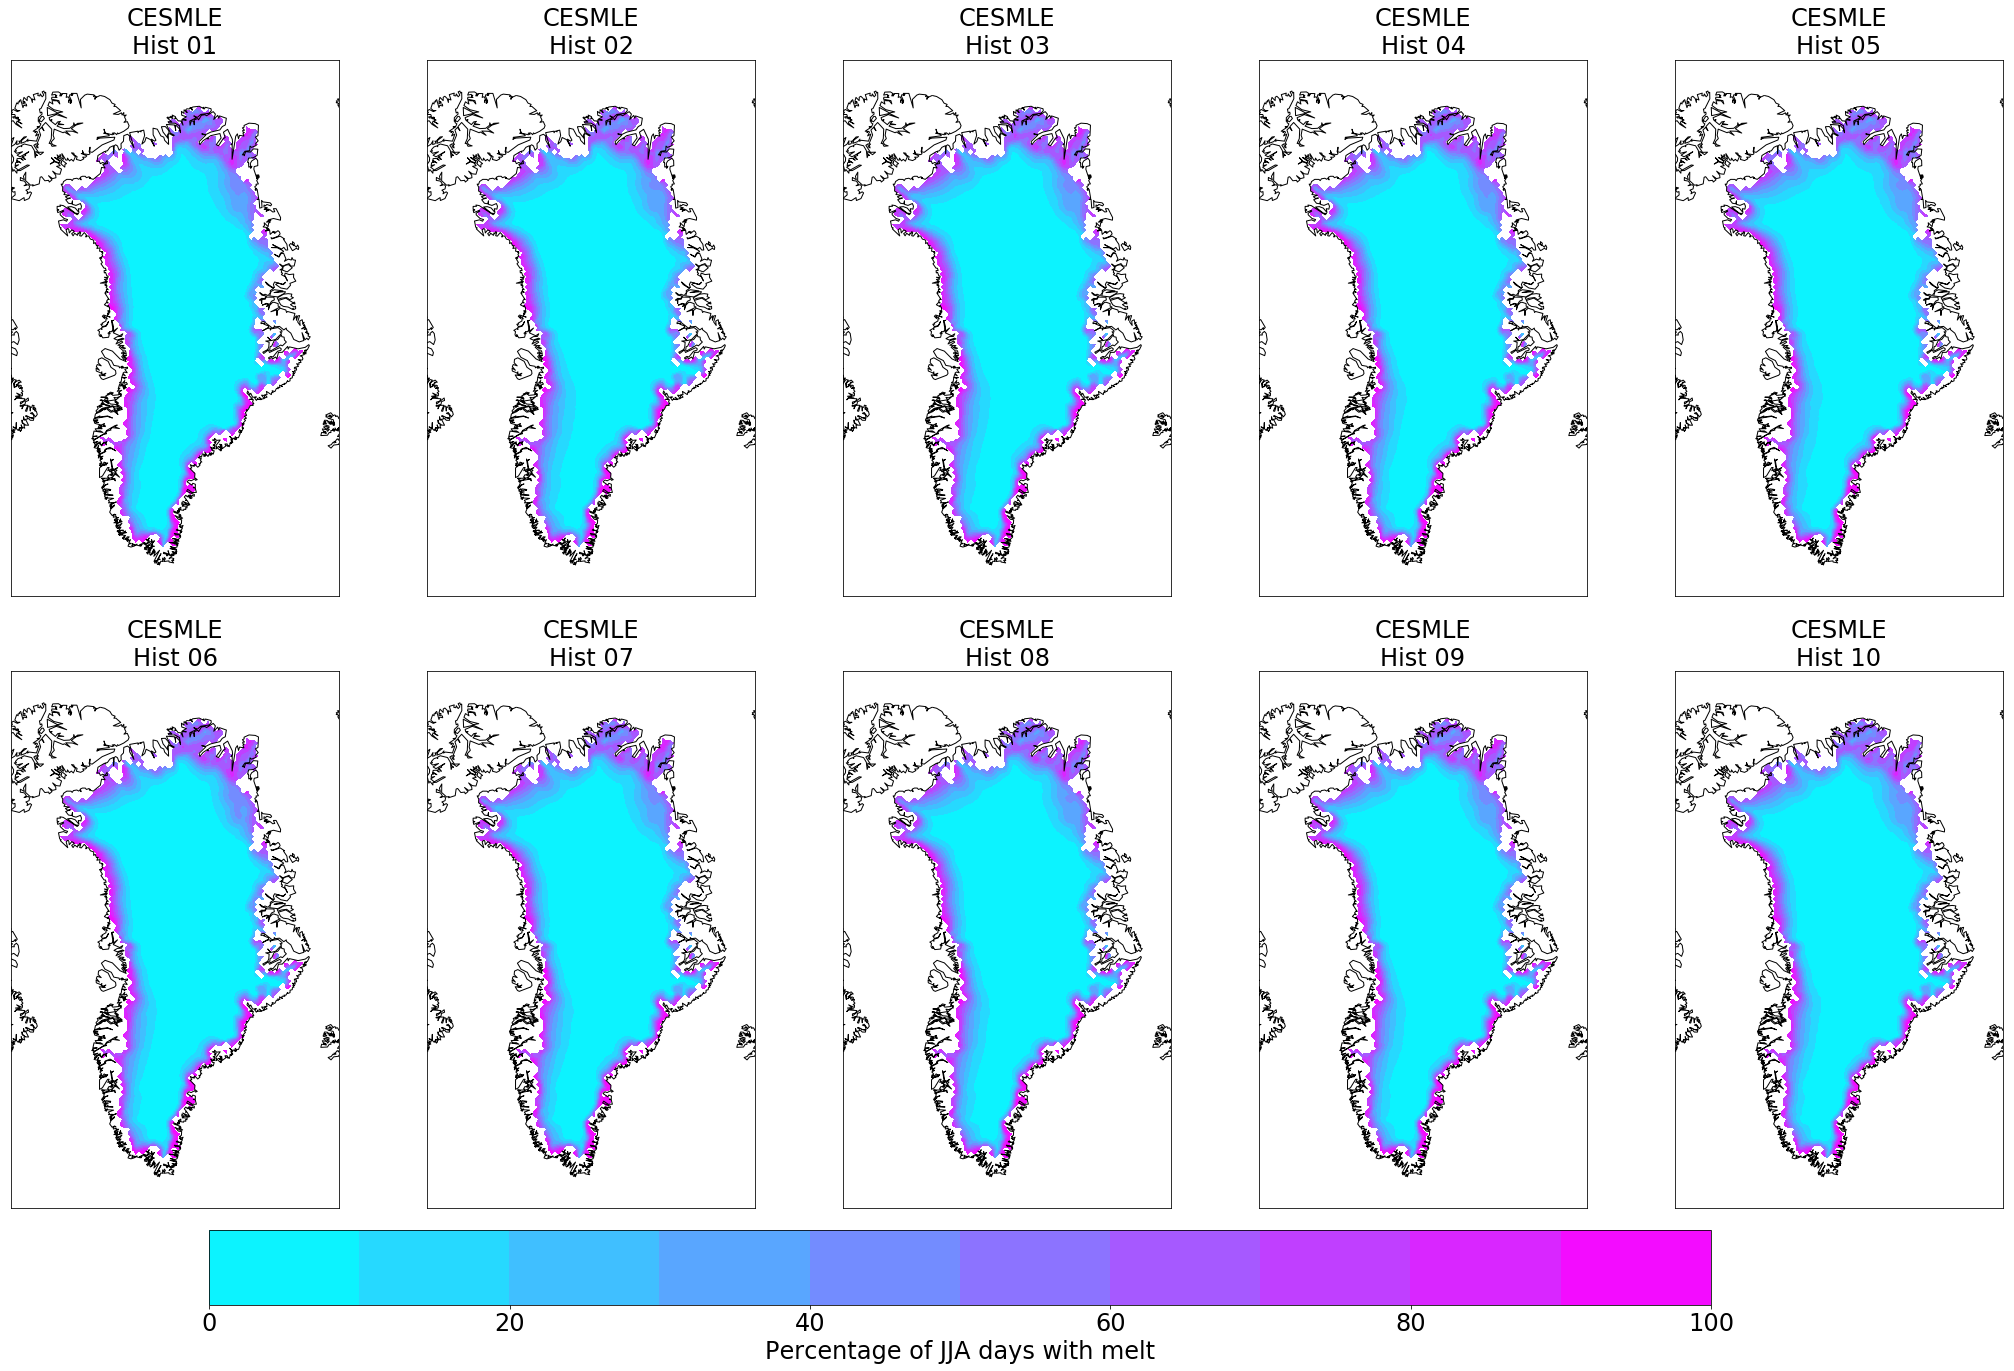

In [79]:
mdlIndex = []
for e in ensList[:-1]:
    mdlIndex.append( e+1 )
nPlots = len( mdlIndex )
fig, axes = plt.subplots(nrows=2, ncols=nPlots/2, figsize=(3*nPlots,2.5*nPlots))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.linspace( 0., 100., 11 )
for index in range( nPlots ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltFrac[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("cool") )
    axesF[index].set_title( createTitle( models[mdlIndex[index]], \
                                         branches[mdlIndex[index]], \
                                         ensIndex[mdlIndex[index]], \
                                         mms ),  fontsize=24);

plt.tight_layout( pad=8, h_pad=20 )    

createColorBar( cs, 'Percentage of '+mms+' days with melt', axes, fontSize=24 )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_ensmbrs_hist" )

Plot melt frac: rcp85 ensemble members
---

Saving figure to wrf_iuggmelt_tas_meltFrac_ensmbrs_hist.eps


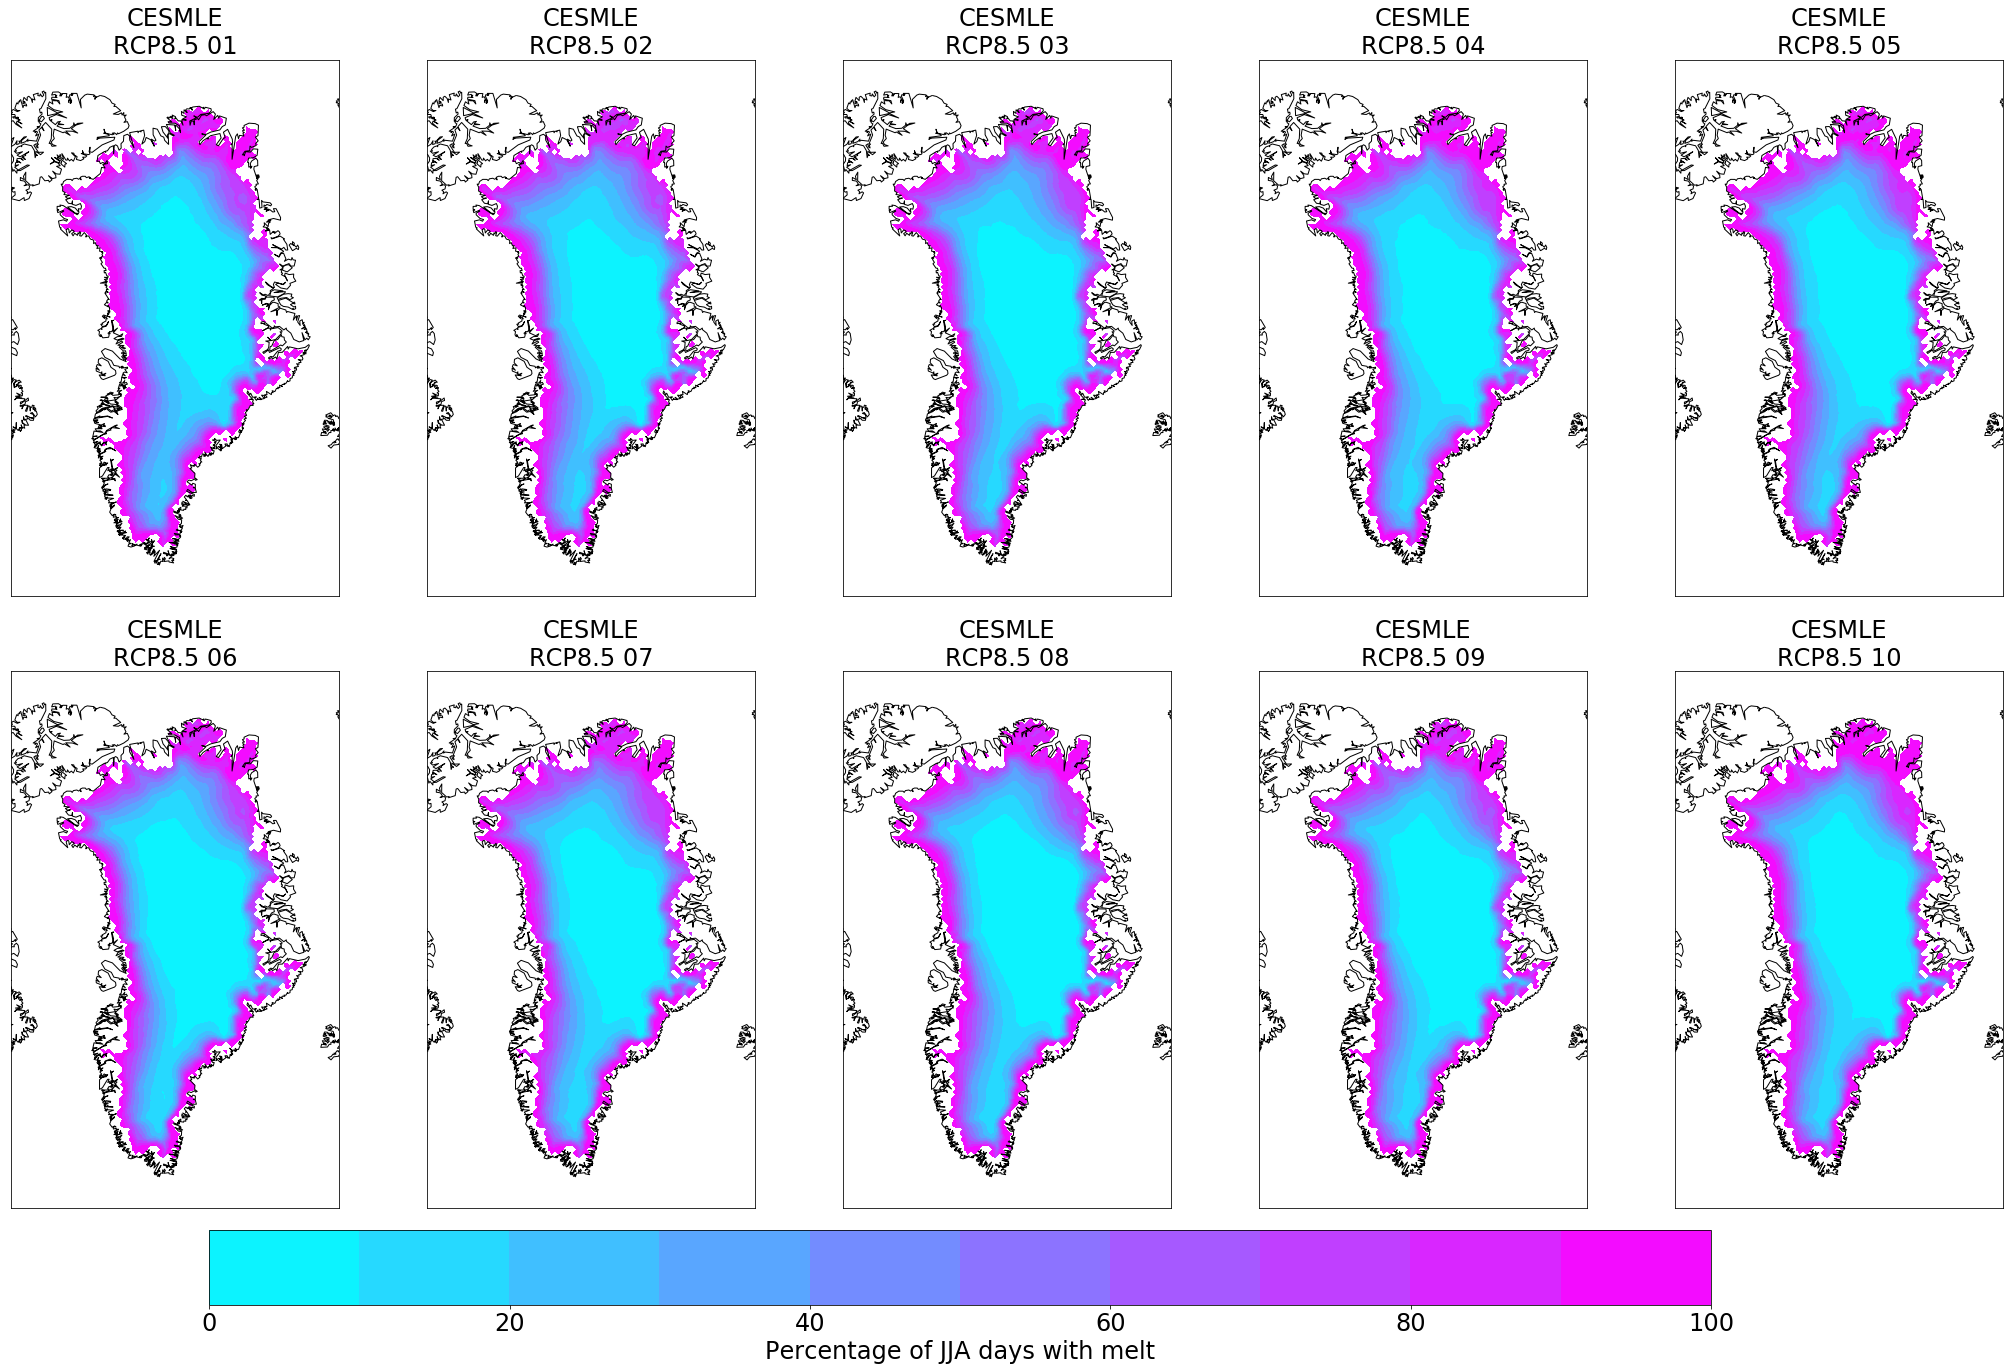

In [78]:
mdlIndex = []
for e in ensList[:-1]:
    mdlIndex.append( e+1+11 )
nPlots = len( mdlIndex )
fig, axes = plt.subplots(nrows=2, ncols=nPlots/2, figsize=(3*nPlots,2.5*nPlots))
axesF = axes.flat

# cLev = np.linspace( 0, nRec, 20 )
cLev = np.linspace( 0., 100., 11 )
for index in range( nPlots ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, meltFrac[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("cool") )
    axesF[index].set_title( createTitle( models[mdlIndex[index]], \
                                         branches[mdlIndex[index]], \
                                         ensIndex[mdlIndex[index]], \
                                         mms ),  fontsize=24);

plt.tight_layout( pad=8, h_pad=20 )    

createColorBar( cs, 'Percentage of '+mms+' days with melt', axes, fontSize=24 )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltFrac_ensmbrs_rcp85" )

Try to highlight changes
---

In [194]:
# calculate difference future - present
indexHist = range(2,12)
indexRCP = range(13,23)
timeDiff = meltSum[indexRCP,:,:] - meltSum[indexHist,:,:]

Saving figure to wrf_iuggmelt_tas_meltSum_ensmbrs_hist_diff.eps


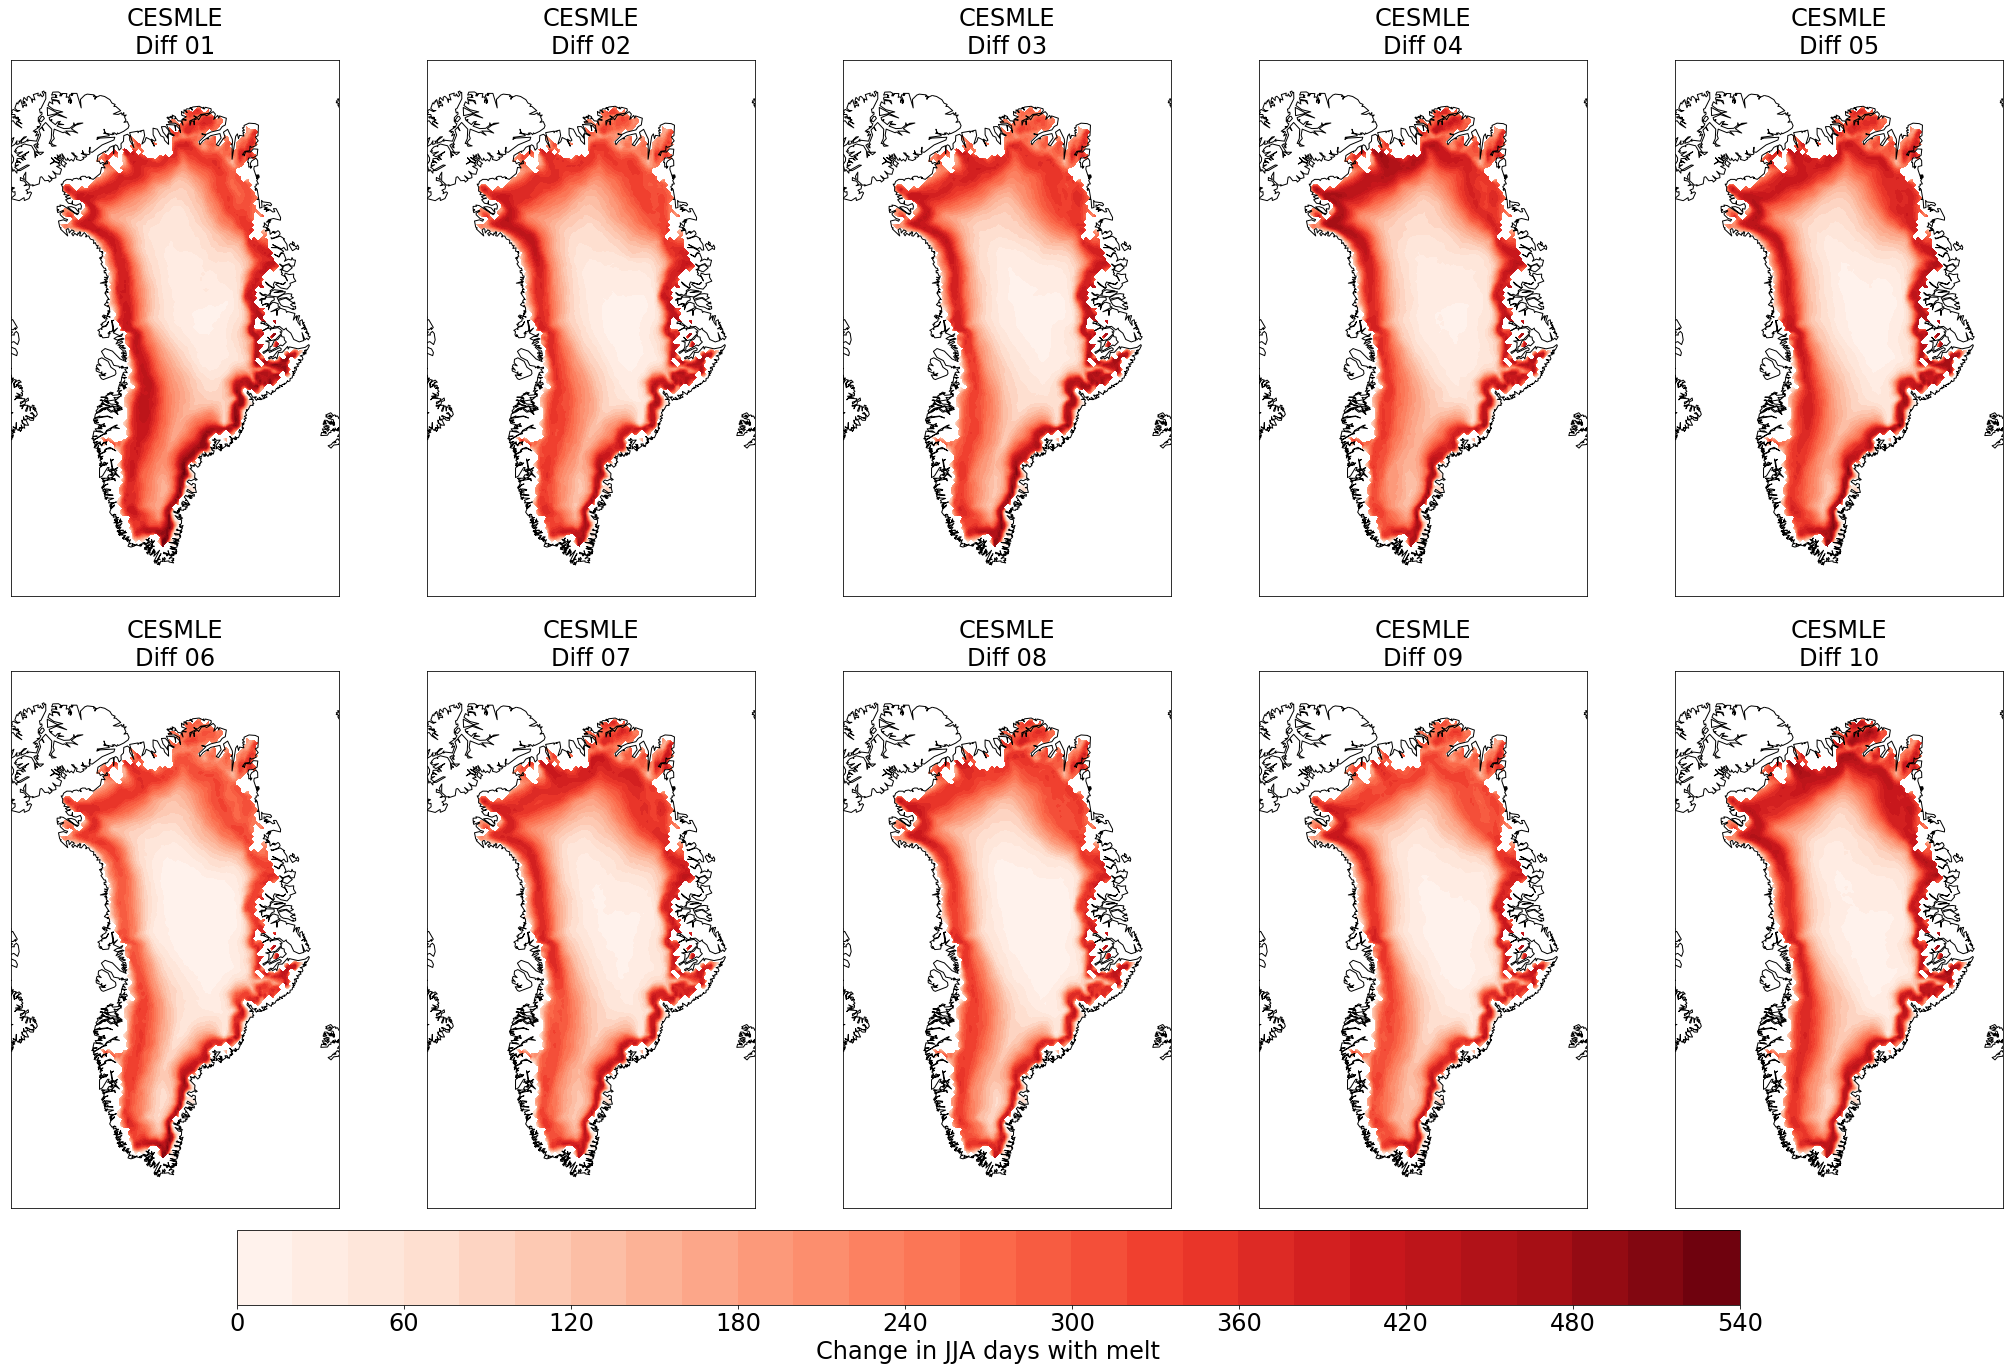

In [195]:
# do plots
mdlIndex = range(0,10)
nPlots = len( mdlIndex )

modelsSub   = models[min(indexHist):(max(indexHist)+1)]
branchesSub = nPlots*"Diff ".split(' ')[:-1]
ensIndexSub = ensIndex[min(indexHist):(max(indexHist)+1)]

fig, axes = plt.subplots(nrows=2, ncols=nPlots/2, figsize=(3*nPlots,2.5*nPlots))
axesF = axes.flat

cLev = np.arange( 0, np.nanmax(timeDiff), 20 )
for index in range( nPlots ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    cs = m.contourf(x, y, timeDiff[mdlIndex[index],:,:], cLev, cmap = plt.get_cmap("Reds") )
    axesF[index].set_title( createTitle( modelsSub[mdlIndex[index]], \
                                         branchesSub[mdlIndex[index]], \
                                         ensIndexSub[mdlIndex[index]], \
                                         mms ),  fontsize=24);

plt.tight_layout( pad=8, h_pad=20 )    

createColorBar( cs, 'Change in '+mms+' days with melt', axes, fontSize=24 )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_ensmbrs_hist_diff" )

Create std deviation plot of future ensemble members
---

Saving figure to wrf_iuggmelt_tas_meltSum_ensmbrs_stdev.eps


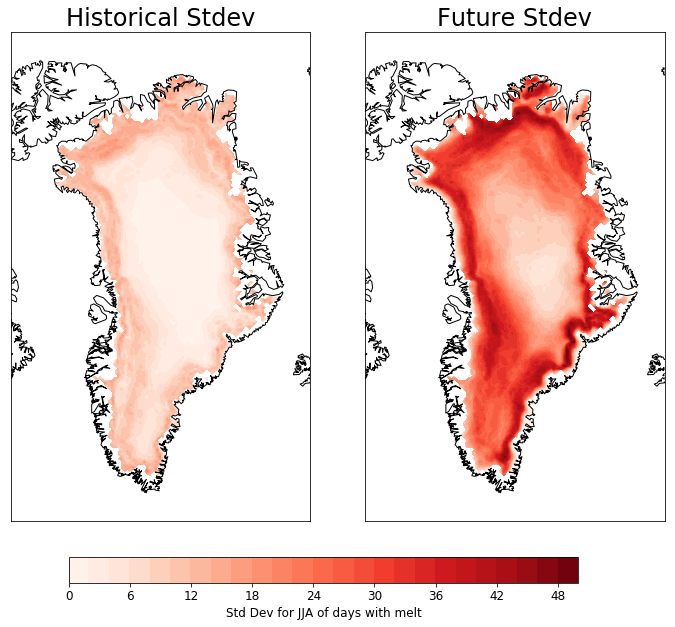

In [196]:
histStd   = np.std( meltSum[indexHist,:,:], axis=0 )
futureStd = np.std( meltSum[indexRCP,:,:], axis=0 )

nPlots = 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axesF = axes.flat
titlePrefix = ['Historical', 'Future']

cLev = np.arange( 0, np.nanmax(futureStd), 2 )
for index in range( nPlots ):
    m = Basemap( projection='stere', width=1900000, height=3100000, \
                 lat_ts=midLat, lat_0=midLat, lon_0=midLon, resolution='l', \
                 ax = axesF[index] )
    if index == 0:
        x, y = m( lon, lat )
    m.drawcoastlines();
    if index == 0:
        cs = m.contourf(x, y, histStd, cLev, cmap = plt.get_cmap("Reds") )
        axesF[index].set_title( titlePrefix[index]+' Stdev',  fontsize=24);
    else:
        cs = m.contourf(x, y, futureStd, cLev, cmap = plt.get_cmap("Reds") )
        axesF[index].set_title( titlePrefix[index]+' Stdev',  fontsize=24);

# cbar = fig.colorbar( cs )
plt.tight_layout( w_pad=1 )  

createColorBar( cs, 'Std Dev for '+mms+' of days with melt', axes, fontSize=12, cbdy=0.04 )

P.saveFigure2( "wrf_"+plotStr+"_"+predVar+"_meltSum_ensmbrs_stdev" )